In [237]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob
import os
import datetime as dt
from datetime import datetime
import bz2
import pickle
import _pickle as cPickle

%matplotlib inline

In [233]:
tickers = pd.read_csv('danish_first_north.csv', header=None)

In [234]:
tickers = tickers[0].to_list()

In [235]:
#tickers = ['SPY', 'EZA', 'ASTGRPJ.CO']
stocks = download_tickers(tickers)

[*********************100%***********************]  4 of 4 completed


In [236]:
stocks

Stock ticker   AGILC.CO                                                       \
Data type          Open       High        Low      Close  Adj Close   Volume   
Date                                                                           
2006-01-09          NaN        NaN        NaN        NaN        NaN      NaN   
2006-01-11          NaN        NaN        NaN        NaN        NaN      NaN   
2006-01-12          NaN        NaN        NaN        NaN        NaN      NaN   
2006-02-08          NaN        NaN        NaN        NaN        NaN      NaN   
2006-02-10          NaN        NaN        NaN        NaN        NaN      NaN   
...                 ...        ...        ...        ...        ...      ...   
2020-08-31    19.500000  20.000000  19.500000  19.900000  19.900000   4117.0   
2020-09-01    19.900000  19.900000  19.900000  19.900000  19.900000    333.0   
2020-09-02    19.900000  19.900000  19.900000  19.900000  19.900000     32.0   
2020-09-03    19.799999  19.799999  19.500000  19.600000  19.600000   1540.0   
2020-09-04    19.500000  20.000000  19.299999  19.799999  19.799999  17734.0   

Stock ticker ASTGRP.CO                    ...  WATURU.CO             \
Data type         Open  High   Low Close  ...        Low      Close   
Date                                      ...                         
2006-01-09         NaN   NaN   NaN   NaN  ...        NaN        NaN   
2006-01-11         NaN   NaN   NaN   NaN  ...        NaN        NaN   
2006-01-12         NaN   NaN   NaN   NaN  ...        NaN        NaN   
2006-02-08         NaN   NaN   NaN   NaN  ...        NaN        NaN   
2006-02-10         NaN   NaN   NaN   NaN  ...        NaN        NaN   
...                ...   ...   ...   ...  ...        ...        ...   
2020-08-31        5.02  5.02  4.76  4.85  ...  26.500000  26.600000   
2020-09-01        4.77  4.99  4.77  4.94  ...  25.500000  27.000000   
2020-09-02        4.97  4.97  4.56  4.79  ...  25.299999  27.000000   
2020-09-03        4.83  5.00  4.79  4.94  ...  25.700001  25.799999   
2020-09-04        4.94  4.96  4.56  4.79  ...  24.500000  24.700001   

Stock ticker                     WIRTEK.CO                               \
Data type     Adj Close   Volume      Open       High    Low      Close   
Date                                                                      
2006-01-09          NaN      NaN     38.00  38.000000  38.00  38.000000   
2006-01-11          NaN      NaN     46.50  46.500000  46.00  46.000000   
2006-01-12          NaN      NaN     42.50  44.099998  42.50  42.799999   
2006-02-08          NaN      NaN     39.00  40.500000  39.00  39.000000   
2006-02-10          NaN      NaN     36.50  39.000000  36.50  36.500000   
...                 ...      ...       ...        ...    ...        ...   
2020-08-31    26.600000  37243.0      9.25   9.350000   8.80   9.100000   
2020-09-01    27.000000  16715.0      8.80   9.000000   8.55   9.000000   
2020-09-02    27.000000  15603.0      8.80   8.950000   8.55   8.550000   
2020-09-03    25.799999   7080.0      8.60   8.950000   8.55   8.950000   
2020-09-04    24.700001  28553.0      8.95   8.950000   8.55   8.850000   

Stock ticker                      
Data type     Adj Close   Volume  
Date                              
2006-01-09    30.234983    200.0  
2006-01-11    36.600246    100.0  
2006-01-12    34.054142   4100.0  
2006-02-08    31.030645      0.0  
2006-02-10    29.041500      0.0  
...                 ...      ...  
2020-08-31     9.100000   9283.0  
2020-09-01     9.000000  14775.0  
2020-09-02     8.550000  20990.0  
2020-09-03     8.950000  18184.0  
2020-09-04     8.850000  16680.0  

[3573 rows x 180 columns]

In [168]:
sns.lineplot(data=stocks.loc[:, stocks.columns.get_level_values(1).isin(['Volume'])])

ValueError: These `style` levels are missing dashes: {'MDUNDO.CO', 'NPINV.CO', 'ODICO.CO', 'GREENM.CO', 'HYPE.CO', 'STENO.CO', 'WATURU.CO', 'MONSO.CO', 'SHAPE.CO', 'LEDIBOND.CO', 'KONSOL.CO', 'HAPPY.CO', 'ERRIA.CO', 'FASTPC.CO', 'WIRTEK.CO', 'ENALYZ.CO', 'PENNEO.CO', 'SLXIT.CO', 'JOBNDX.CO', 'FOM.CO', 'VIRO.CO', 'HRC.CO', 'SCAPE.CO', 'ESOFT.CO'}

In [230]:
def download_tickers(tickers):
    # Fetch downloaded ticker from raw_data
    downloaded_tickers = [x[0:-5] if '.pbz2' in x else '' for x in os.listdir('raw_data/')]
    downloaded_tickers.remove('')
    # Check if tickers already are downloaded
    tickers_to_download = []
    for ticker in tickers:
        if ticker in downloaded_tickers:
            # If already downloaded, check if they need updates
            if update_ticker(ticker):
                tickers_to_download.append(ticker)
        else:
            tickers_to_download.append(ticker)

    not_downloaded = download_dump(tickers_to_download)
    tickers_to_load = [x for x in tickers if x not in not_downloaded]
    # Read tickers from json and return
    return load_stocks(tickers_to_load)

In [219]:
def load_stocks(tickers):
    cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    index = pd.MultiIndex.from_product([tickers, cols], names=['Stock ticker', 'Data type'])
    if len(tickers) > 1:
        data = pd.concat([decompress_pickle('raw_data/' + x + '.pbz2') for x in tickers], axis=1, sort=True)
    else:
        data = decompress_pickle('raw_data/' + tickers[0] + '.pbz2')
    
    data.columns = index
    try:
        data.index = pd.to_datetime(data.index, unit='ms')
    except ValueError:
        data.index = pd.to_datetime(data.index)
    return data

In [220]:
def update_ticker(ticker):
    last_bday = last_weekday()
    newest_date = decompress_pickle('raw_data/' + ticker + '.pbz2').index[-1]
    if newest_date == float:
        newest_date = dt.datetime.fromtimestamp(newest_date/1000).date()
    if newest_date != last_bday:
        return True 
    else:
        return False

In [223]:
def download_dump(tickers):
    not_downloaded = []
    if tickers != []:
        data = yf.download(tickers, period='100y', group_by='tickers')
        if len(tickers) > 1:
            for ticker in tickers:
                    clean_data = clean_df(data[ticker])
                    if len(clean_data) > 1:
                        compressed_pickle(ticker, clean_data)
                    else:
                        not_downloaded.append(tickers)
        else:
            clean_data = clean_df(data)
            if len(clean_data) > 1:
                compressed_pickle(tickers[0], clean_data)
            else:
                not_downloaded.append(tickers[0])
                
    return not_downloaded 

In [224]:
def last_weekday():
    todays_day = dt.date.today().day
    if todays_day in [5, 6]:
        return dt.date.today() - dt.timedelta(days=todays_day-4)
    else:
        return dt.date.today()


In [225]:
def clean_df(df):
    df = df.dropna(axis = 0, how='all')
    return df

In [226]:
def compressed_pickle(ticker, data):
    with bz2.BZ2File('raw_data/' + ticker + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)

In [227]:
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

In [204]:
test = decompress_pickle('raw_data/EZA.pbz2')

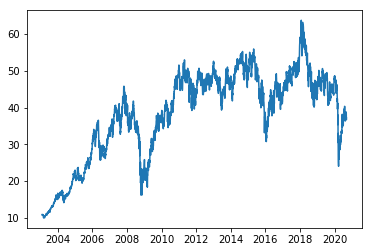

In [180]:
sns.lineplot(data=test['Adj Close'])

In [ ]:
import os

def clean_raw_files():
    for filename in os.listdir('raw_data'):
        if filename.endswith(".pbz2"): 
            df = pd.DataFrame(decompress_pickle('raw_data/' + filename))
            non_zeroes = len(df) - df.iloc[:, 4].isna().sum()
            if non_zeroes < 2:
                os.remove('raw_data/' + filename)
            else:
                df = df.dropna(how='all', axis=0)
                ticker = filename.replace('.pbz2', '')
                compressed_pickle(ticker, df)
                  
remove_empties()